In [2]:
# kaggle.json is in current directory
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d l3llff/flowers

 99% 225M/228M [00:09<00:00, 30.7MB/s]
100% 228M/228M [00:09<00:00, 25.1MB/s]


In [3]:
!unzip -qq flowers.zip

In [4]:
import os
import pathlib
import random
import numpy as np
from PIL import Image
import cv2
import tensorflow as tf

class ImageGenerator():
    def __init__(self, folders, target_size, 
                 batch_size, convert_to_grayscale=False):
        self.folders = folders
        self.target_size = target_size
        self.batch_size = batch_size
        self.convert_to_grayscale = convert_to_grayscale
        self.files = self._build()
        self.start_index = 0
        self.end_index = batch_size
    
    @property
    def _channels(self):
        if self.convert_to_grayscale:
            return 1
        return 3
    
    @property
    def steps_per_epoch(self):
        return len(self.files) // self.batch_size
    
    def _build(self):
        files = []
        for path in self.folders:
            path = pathlib.Path(path)
            fnames = os.listdir(path)
            for fname in fnames:
                files.append(path / fname)
        random.shuffle(files)
        random.shuffle(files)
        
        return files
    
    def reset_index(self):
        random.shuffle(self.files)
        self.start_index = 0
        self.end_index = self.batch_size
        
    def _get_batch(self, fnames):
        X = np.zeros(shape=(self.batch_size, 
                            *self.target_size, 
                            self._channels),
                     dtype='float32')
        for i, fname in enumerate(fnames):
            img = Image.open(fname)
            if self.convert_to_grayscale:
                img = img.convert('L')
            img = img.resize(self.target_size)
            img = np.array(img) / 255.
            if self.convert_to_grayscale:
                img = img[..., np.newaxis]
            if img.ndim != 3:
              continue
            X[i] = img
        
        return X, X
    
    def flow(self, training=True):
        while True:
            fnames = self.files[self.start_index: self.end_index]
            self.start_index += self.batch_size
            self.end_index += self.batch_size
            if self.end_index > len(self.files):
                self.reset_index()
            
            if training:
              yield self._get_batch(fnames)
            else:
              yield self._get_batch(fnames)[0]
        


class TrackImageCallback(tf.keras.callbacks.Callback):
    def __init__(self, image_sample, show_window=True, 
                 to_file=None, fps=30):
        super(TrackImageCallback, self).__init__()
        self.image_sample = image_sample
        self.size = (256, 256)
        self.at_epoch = 0
        self.show_window = show_window
        self.to_file = to_file
        self.fps = fps
        if to_file is not None:
          self._video_encoding = cv2.VideoWriter_fourcc('M','J','P','G')
          self._video_writer = cv2.VideoWriter(self.to_file, 
                                               self._video_encoding,
                                               fps=fps,
                                               frameSize=self.size)
        
    def on_train_begin(self, logs):
        original_image_upscaled = cv2.resize(self.image_sample, self.size)
        original_image_upscaled = self._to_uint8_bgr(original_image_upscaled)
        if self.show_window:
          cv2.imshow('Tracked Image', original_image_upscaled)
          cv2.waitKey(1)
        if self.to_file is not None:
          for _ in range(2 * self.fps):
            self._video_writer.write(original_image_upscaled)

        
    def on_train_batch_end(self, batch, logs):
        printed = f'epoch: {self.at_epoch}\nbatch: {batch}'
        for key, value in logs.items():
            printed += f'\n{key}: {value:.3}'
        
        predicted = self._predict_and_upscale()
        for i, line in enumerate(printed.split('\n')):
            predicted = cv2.putText(img=predicted,
                                    text=line,
                                    org=(2, 10 + i*20),
                                    fontFace=cv2.FONT_HERSHEY_DUPLEX,
                                    fontScale=0.55,
                                    thickness=1,
                                    color=(0, 255, 0))
            
        if self.show_window:
          cv2.imshow('Tracked Image', predicted)
          cv2.waitKey(1)
        if self.to_file is not None:
          self._video_writer.write(predicted)
    
    def on_epoch_begin(self, epoch, logs):
        self.at_epoch = epoch
        
    def on_train_end(self, logs):
        if self.show_window:
          cv2.destroyWindow('Tracked Image')
    
    def _predict_and_upscale(self):
        x = np.expand_dims(self.image_sample, axis=0)
        predicted = self.model.predict(x)[0]
        predicted = cv2.resize(predicted, self.size)
        predicted = self._to_uint8_bgr(predicted)
        return predicted
    
    def _to_uint8_bgr(self, image):
      image = image[:, :, ::-1]
      image = (255 * image).astype(np.uint8)
      return image

def get_random_image(species_folder, target_size):
    image_name = random.choice(os.listdir(species_folder))
    image_path = os.path.join(species_folder, image_name)
    image_sample = Image.open(image_path).resize(target_size)
    image_sample = np.array(image_sample) / 255
    return image_sample

In [5]:
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Flatten, Reshape
from tensorflow.keras.models import Model
import tensorflow as tf

class AutoEncoder():
    def __init__(self, input_shape, layer_filters,
                 activation, latent_dim):
        self.input_shape = input_shape
        self.layer_filters = layer_filters
        self.kernel_size = 3
        self.activation = activation
        self.latent_dim = latent_dim
        self.encoder = self._build_encoder()
        self.decoder = self._build_decoder()
        self.autoencoder = self._build_autoencoder()
    
    def _build_encoder(self):
        inputs = Input(self.input_shape, name='encoder_input')
        x = inputs
        for filters in self.layer_filters:
            x = Conv2D(filters,
                       kernel_size=self.kernel_size,
                       activation=self.activation,
                       strides=2,
                       padding='same')(x)
        self.shape = x.shape[1:]
        x = Flatten()(x)
        latent = Dense(self.latent_dim, name='latent_vector')(x)
        
        model = Model(inputs, latent, name='Encoder')
        return model
    
    def _build_decoder(self):
        inputs = Input(self.latent_dim, name='decoder_input')
        x = Dense(self.shape[0] * self.shape[1] * self.shape[2])(inputs) 
        x = Reshape(self.shape)(x)
        for filters in self.layer_filters[::-1]:
            x = Conv2DTranspose(filters,
                                kernel_size=self.kernel_size,
                                activation=self.activation,
                                strides=2,
                                padding='same')(x)
        outputs = Conv2D(self.input_shape[-1],
                         kernel_size=1,
                         activation='sigmoid',
                         padding='same',
                         name='decoder_output')(x)
        
        model = Model(inputs, outputs, name='Decoder')
        return model
    
    def _build_autoencoder(self):
        inputs = Input(shape=self.input_shape, name='autoencoder_input')
        outputs = self.decoder(self.encoder(inputs))
        model = Model(inputs, outputs, name='AutoEncoder')
        return model

    def train(self, 
              train_gen,  
              val_gen=None, 
              epochs=1, 
              steps_per_epoch=1,
              optimizer='adam',
              loss='mse', 
              vloss_weight=0.5,
              callbacks=None):
                    
        self.autoencoder.compile(optimizer=optimizer,
                                 loss=[loss, self._total_variation_loss],
                                 loss_weights=[1 - vloss_weight, vloss_weight],
                                 )
        self.autoencoder.fit(x=train_gen,
                             epochs=epochs,
                             steps_per_epoch=steps_per_epoch,
                             validation_data=val_gen,
                             callbacks=callbacks
                             )           
        
    @tf.function
    def _total_variation_loss(X_in, X_out):
        vertical_variation = tf.square(
            X_out[:, 1:, :, :] - X_out[:, :-1, :, :])
        horizontal_variation = tf.square(
            X_out[:, :, 1:, :] - X_out[:, :, :-1, :])
        total_variation_loss = tf.sqrt(tf.reduce_sum(
                        horizontal_variation + vertical_variation))
        return total_variation_loss        

In [6]:
import os
import pathlib

flowers_path = 'flowers'
root = pathlib.Path(flowers_path)
species = os.listdir(root)
speices_counts = [len(os.listdir(root / kind))
                  for kind in species]
print(f"Found {len(species)} flower species")
print(*zip(species, speices_counts), sep='\n')

Found 16 flower species
('common_daisy', 980)
('bellflower', 873)
('daffodil', 970)
('astilbe', 737)
('rose', 999)
('dandelion', 1052)
('magnolia', 1048)
('coreopsis', 1047)
('california_poppy', 1022)
('calendula', 978)
('tulip', 1048)
('black_eyed_susan', 1000)
('carnation', 923)
('sunflower', 1027)
('water_lily', 982)
('iris', 1054)


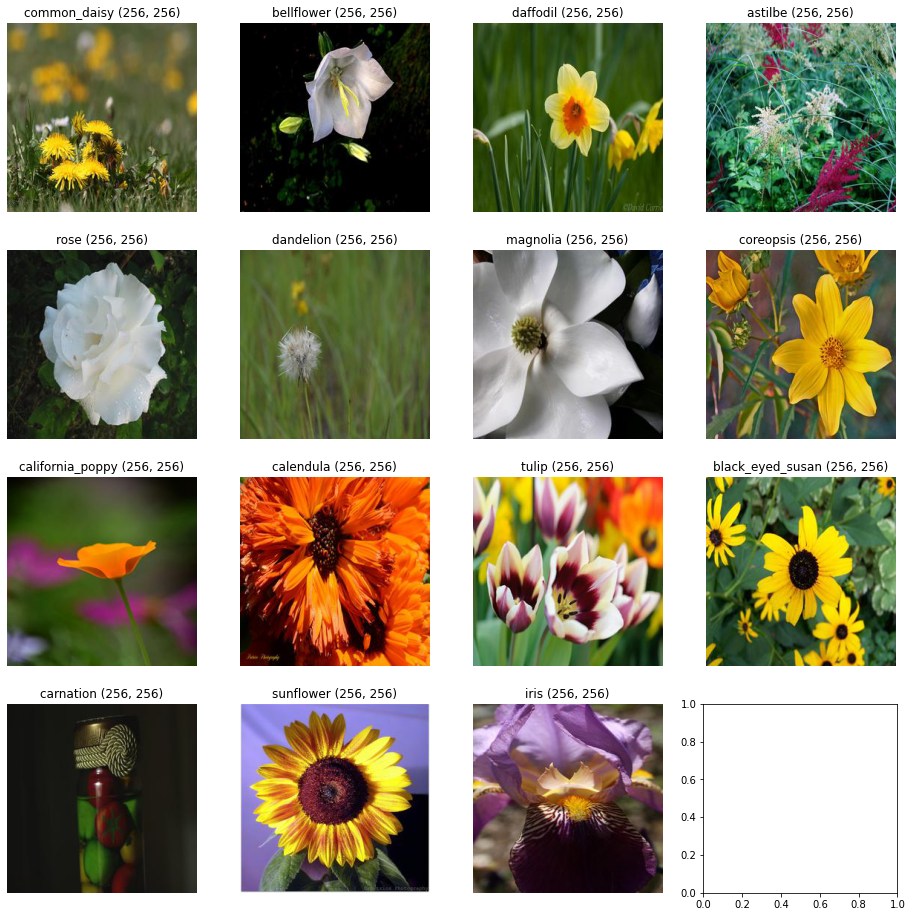

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image

fig, axes = plt.subplots(4, 4, figsize=(16, 16))
for i, kind in enumerate(species):
  kind_dir = root / kind
  random_flower = random.choice(os.listdir(kind_dir))
  random_flower = os.path.join(kind_dir, random_flower)
  random_flower = Image.open(random_flower)
  size = random_flower.size
  random_flower = np.array(random_flower)
  
  ax = axes.ravel()[i]
  ax.imshow(random_flower)
  ax.set_axis_off()
  ax.set_title(kind + ' ' + str(size))

In [ ]:
# Params
rose_folder = root / 'rose'
target_size = (128, 128)
input_shape = target_size + (3,)
batch_size = 32
layer_filters = [64, 128, 256, 512, 512, 1024]
latent_dim = 32
activation = 'relu'



rose_gen = ImageGenerator(folders=[rose_folder],
                          target_size=target_size,
                          batch_size=batch_size)
rose_ae = AutoEncoder(input_shape=input_shape,
                      layer_filters=layer_filters,
                      activation=activation,
                      latent_dim=latent_dim)

print(rose_ae.encoder.summary())
print()
print(rose_ae.decoder.summary())


# training 
epochs = 300
steps_per_epoch = len(rose_gen.files) // batch_size
image_sample = get_random_image(species_folder=root / 'rose',
                                target_size=target_size)
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                     patience=10, 
                                     restore_best_weights=True),  
    TrackImageCallback(image_sample=image_sample,
                       show_window=False,
                       to_file='rose.avi')
            ]

rose_ae.train(rose_gen.flow(),
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              vloss_weight=0.1,
              callbacks=callbacks
              )

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 512)         1180160   
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 512)         2359808   
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 2, 1024)        4719

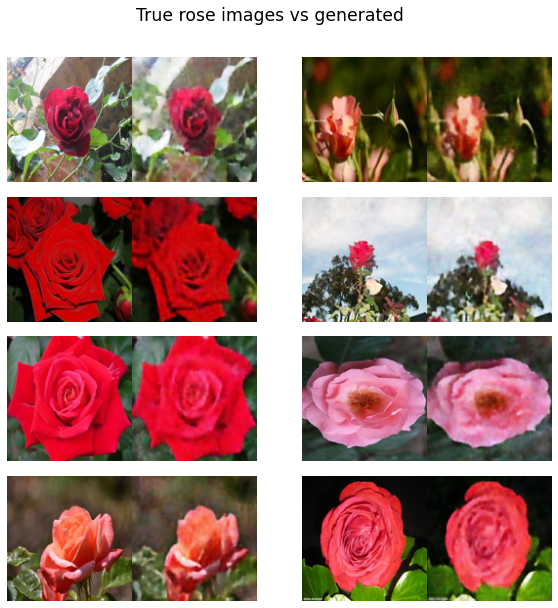

In [ ]:
X = next(rose_gen.flow(training=False))
X = X[:8]
Y = rose_ae.autoencoder.predict(X)

fig, axes = plt.subplots(4, 2, figsize=(10, 10))
fig.subplots_adjust(wspace=0.12, hspace=.12)
for i, ax in enumerate(axes.ravel()):
  dual = np.hstack((X[i], Y[i]))
  ax.imshow(dual)
  ax.set_axis_off()

fig.suptitle('True rose images vs generated', y=0.95, fontsize='xx-large')
plt.show()

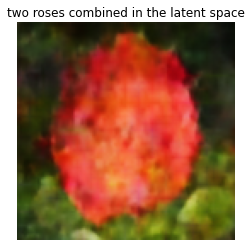

In [ ]:
rose_1, rose_2 = X[6], X[7]
rose_1_vector, rose_2_vector = \
      rose_ae.encoder(np.stack([rose_1, rose_2]))
rose_12_vector = 0.5*rose_1_vector + 0.5*rose_2_vector
rose_12 = rose_ae.decoder(np.expand_dims(rose_12_vector, axis=0))

plt.figure(figsize=(4, 4))
plt.imshow(rose_12[0])
plt.title('two roses combined in the latent space')
plt.axis('off')
plt.show()

In [ ]:
# Params
sunflower_folder = root / 'sunflower'
target_size = (32, 32)
input_shape = target_size + (3,)
batch_size = 32
layer_filters = [32, 64, 64, 128, 128]
latent_dim = 2
activation = 'relu'


sunflower_gen = ImageGenerator(folders=[sunflower_folder],
                               target_size=target_size,
                               batch_size=batch_size)
sunflower_ae = AutoEncoder(input_shape=input_shape,
                           layer_filters=layer_filters,
                           activation=activation,
                           latent_dim=latent_dim)

sunflower_ae.encoder.summary()


# training 
epochs = 300
steps_per_epoch = len(sunflower_gen.files) // batch_size
vloss_weight=0.1
random_sunflower = get_random_image(sunflower_folder, target_size)
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                     patience=10, 
                                     restore_best_weights=True),  
            ]

sunflower_ae.train(sunflower_gen.flow(),
                   epochs=epochs,
                   steps_per_epoch=steps_per_epoch,
                   vloss_weight=vloss_weight,
                   callbacks=callbacks
                  )

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 conv2d_9 (Conv2D)           (None, 2, 2, 128)         73856     
                                                                 
 conv2d_10 (Conv2D)          (None, 1, 1, 128)         147584    
                                                                 
 flatten_1 (Flatten)         (None, 128)               0   

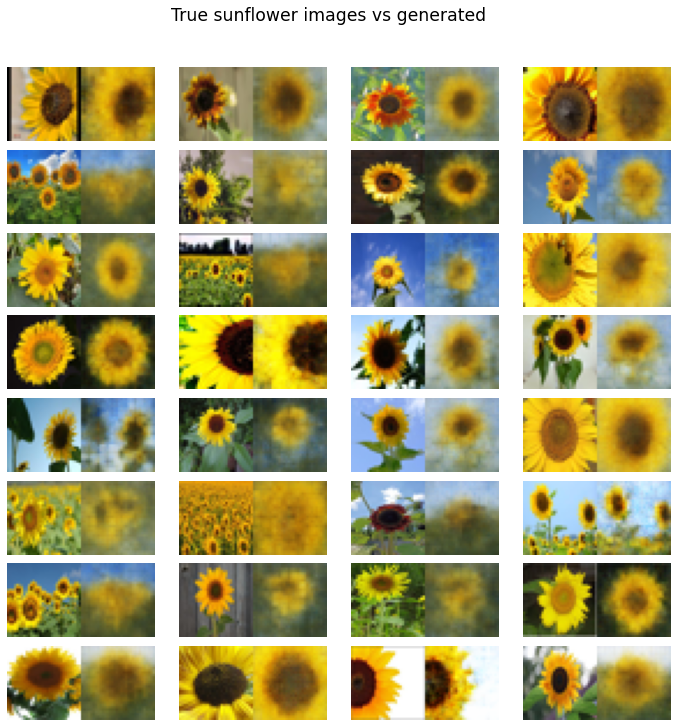

In [ ]:
X_sun = next(sunflower_gen.flow(training=False))
Y_sun = sunflower_ae.autoencoder.predict(X_sun)

fig, axes = plt.subplots(8, 4, figsize=(12, 12))
fig.subplots_adjust(wspace=0.12, hspace=.12)
for i, ax in enumerate(axes.ravel()):
  dual = np.hstack((X_sun[i], Y_sun[i]))
  ax.imshow(dual)
  ax.set_axis_off()

fig.suptitle('True sunflower images vs generated', y=0.95, fontsize='xx-large')
plt.show()

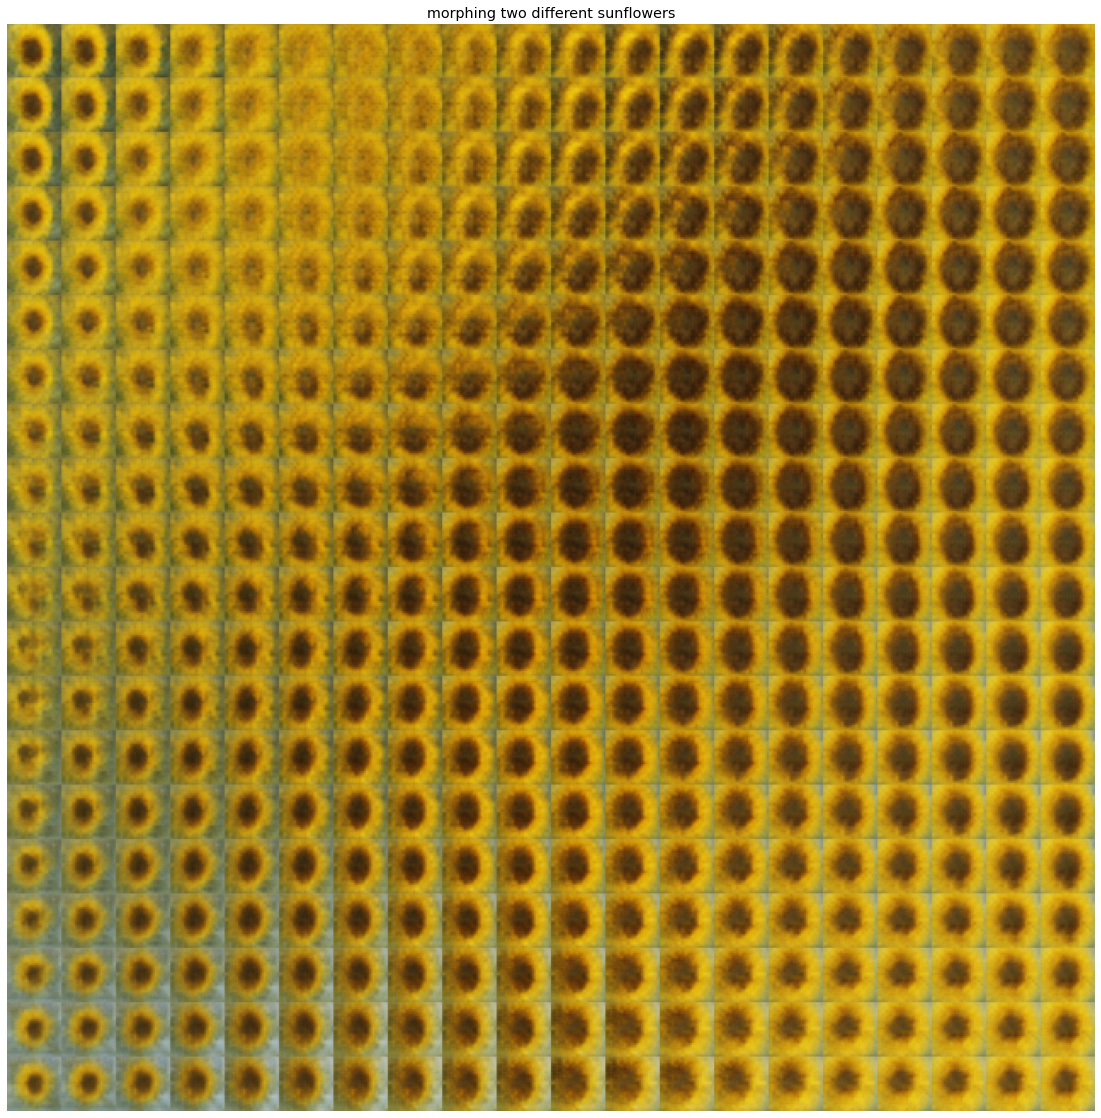

In [ ]:
sunflower_1, sunflower_2 = X_sun[0], X_sun[2]
sunflower_batch_2d = \
  sunflower_ae.encoder(np.stack([sunflower_1, sunflower_2]))

xmin, ymin = np.min(sunflower_batch_2d, axis=0)
xmax, ymax = np.max(sunflower_batch_2d, axis=1)

n_points = 20
x_space = np.linspace(xmin, xmax, n_points)
y_space = np.linspace(ymin, ymax, n_points)
xs, ys = np.meshgrid(x_space, y_space)
ys = ys[::-1]
xs = xs.ravel()
ys = ys.ravel()
vectors = np.stack([xs, ys], axis=1)
generated_sun = sunflower_ae.decoder(vectors)
grid = np.reshape(generated_sun, (n_points, n_points) + input_shape)
grid = np.transpose(grid, axes=(0, 2, 1, 3, 4))
grid = np.vstack(grid)
grid = np.transpose(grid, axes=(1, 0, 2, 3))
grid = np.hstack(grid)

plt.figure(figsize=(n_points, n_points))
plt.imshow(grid)
plt.title('morphing two different sunflowers',
         fontdict={'fontsize': 'x-large'})
plt.axis('off')
plt.show()

In [ ]:
# Params
two_species = ['iris', 'calendula']
folders = [root / species for species in two_species]
target_size = (128, 128)
input_shape = target_size + (3,)
batch_size = 32
layer_filters = [64, 128, 256, 512, 1024, 1024]
latent_dim = 16
activation = 'relu'


duo_gen = ImageGenerator(folders=folders,
                         target_size=target_size,
                         batch_size=batch_size)
duo_ae = AutoEncoder(input_shape=input_shape,
                     layer_filters=layer_filters,
                     activation=activation,
                     latent_dim=latent_dim)


# training 
epochs = 200
steps_per_epoch = len(duo_gen.files) // batch_size
vloss_weight = 0.2
image_sample = get_random_image(folders[0], target_size)
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                     patience=10, 
                                     restore_best_weights=True),  
    TrackImageCallback(image_sample=image_sample,
                       show_window=False,
                       to_file='iris_calendula.avi')
            ]

duo_ae.train(duo_gen.flow(),
             epochs=epochs,
             steps_per_epoch=steps_per_epoch,
             vloss_weight=vloss_weight,
             callbacks=callbacks
             )

Epoch 1/200
63/63 [==============================] - 15s 223ms/step - loss: 0.0583
Epoch 2/200
63/63 [==============================] - 14s 219ms/step - loss: 0.0406
Epoch 3/200
63/63 [==============================] - 13s 214ms/step - loss: 0.0355
Epoch 4/200
63/63 [==============================] - 13s 212ms/step - loss: 0.0295
Epoch 5/200
63/63 [==============================] - 13s 211ms/step - loss: 0.0255
Epoch 6/200
63/63 [==============================] - 13s 212ms/step - loss: 0.0243
Epoch 7/200
63/63 [==============================] - 13s 213ms/step - loss: 0.0236
Epoch 8/200
63/63 [==============================] - 14s 215ms/step - loss: 0.0224
Epoch 9/200
63/63 [==============================] - 13s 213ms/step - loss: 0.0217
Epoch 10/200
63/63 [==============================] - 13s 213ms/step - loss: 0.0215
Epoch 11/200
63/63 [==============================] - 13s 212ms/step - loss: 0.0213
Epoch 12/200
63/63 [==============================] - 13s 212ms/step - loss: 0.0205
E

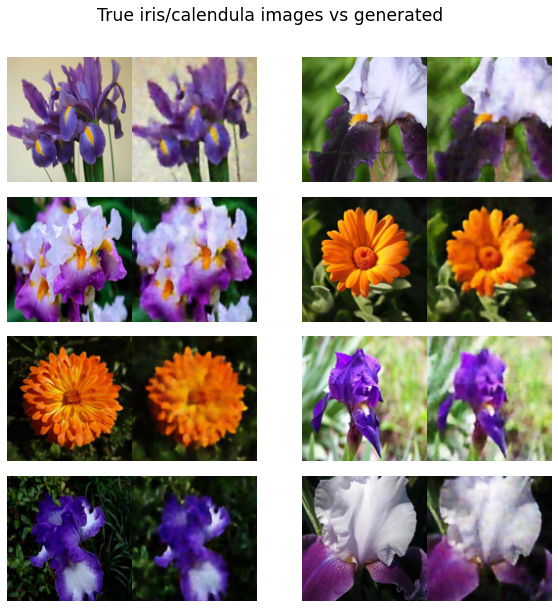

In [ ]:
X_duo = next(duo_gen.flow(training=False))
Y_duo = duo_ae.autoencoder.predict(X_duo)

fig, axes = plt.subplots(4, 2, figsize=(10, 10))
fig.subplots_adjust(wspace=0.12, hspace=.12)
for i, ax in enumerate(axes.ravel()):
  dual = np.hstack((X_duo[i], Y_duo[i]))
  ax.imshow(dual)
  ax.set_axis_off()

fig.suptitle('True iris/calendula images vs generated', y=0.95, fontsize='xx-large')
plt.show()

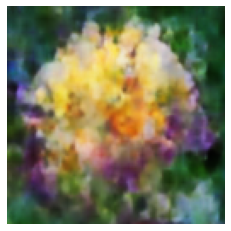

In [ ]:
iris, calendula = X_duo[2], X_duo[4]
iris_vector, calendula_vector = \
      duo_ae.encoder(np.stack([iris, calendula]))
blended_vector = 0.5*iris_vector + 0.5*calendula_vector
blended = duo_ae.decoder(np.expand_dims(blended_vector, axis=0))

plt.figure(figsize=(4, 4))
plt.imshow(blended[0])
plt.axis('off')
plt.show()

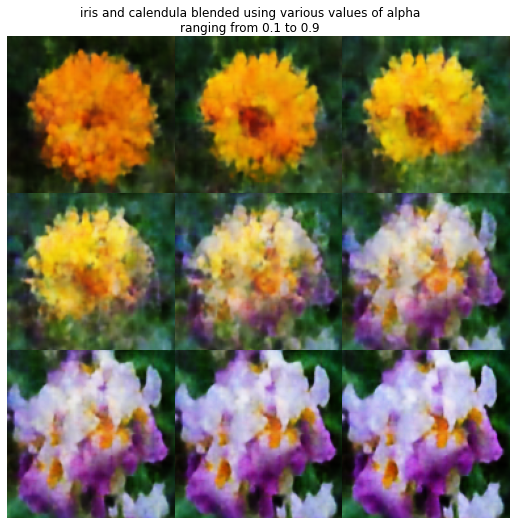

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
fig.subplots_adjust(hspace=-.1, wspace=0)

for i, ax in enumerate(axes.ravel()):
  alpha = 0.1 * (i+1)
  blended_vector = alpha * iris_vector + (1 - alpha) * calendula_vector
  blended = duo_ae.decoder(np.expand_dims(blended_vector, axis=0))
  ax.imshow(blended[0])
  ax.set_axis_off()
  ax.set_xticks(())
  ax.set_yticks(())

fig.suptitle('iris and calendula blended using various values of alpha\n' \
             +'ranging from 0.1 to 0.9', y=0.92)
plt.show()

keras.callbacks.ModelCheckpoint

In [9]:
# Params
species.remove('water_lily')
folders = [root / kind for kind in species]
target_size = (128, 128)
input_shape = target_size + (3,)
batch_size = 32
layer_filters = [64, 128, 256, 512, 1024, 1024]
latent_dim = 16
activation = 'relu'



flowers_gen = ImageGenerator(folders=folders,
                             target_size=target_size,
                             batch_size=batch_size)
flowers_ae = AutoEncoder(input_shape=input_shape,
                         layer_filters=layer_filters,
                         activation=activation,
                         latent_dim=latent_dim)


# training 
epochs = 400
steps_per_epoch = len(flowers_gen.files) // batch_size
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-3)
vloss_weight = 0.2
image_sample = get_random_image(species_folder=root / 'california_poppy',
                                target_size=target_size)
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                     patience=5, 
                                     restore_best_weights=True), 
    tf.keras.callbacks.ModelCheckpoint('flowers_autoencoder.keras',
                                   monitor='loss',
                                   save_best_only=True),
    #TrackImageCallback(image_sample=image_sample,
    #                   show_window=False,
    #                   to_file='flower.avi',
    #                   fps=120)
            ]

flowers_ae.train(flowers_gen.flow(),
                 epochs=epochs,
                 steps_per_epoch=steps_per_epoch,
                 optimizer=optimizer,
                 vloss_weight=vloss_weight,
                 callbacks=callbacks
                )

Epoch 1/400
461/461 [==============================] - 109s 206ms/step - loss: 0.0345
Epoch 2/400
461/461 [==============================] - 96s 209ms/step - loss: 0.0247
Epoch 3/400
461/461 [==============================] - 97s 210ms/step - loss: 0.0234
Epoch 4/400
461/461 [==============================] - 96s 208ms/step - loss: 0.0230
Epoch 5/400
461/461 [==============================] - 96s 208ms/step - loss: 0.0223
Epoch 6/400
461/461 [==============================] - 96s 208ms/step - loss: 0.0218
Epoch 7/400
461/461 [==============================] - 96s 207ms/step - loss: 0.0216
Epoch 8/400
461/461 [==============================] - 95s 207ms/step - loss: 0.0214
Epoch 9/400
461/461 [==============================] - 95s 207ms/step - loss: 0.0211
Epoch 10/400
461/461 [==============================] - 95s 207ms/step - loss: 0.0209
Epoch 11/400
461/461 [==============================] - 95s 207ms/step - loss: 0.0207
Epoch 12/400
461/461 [==============================] - 95s 20

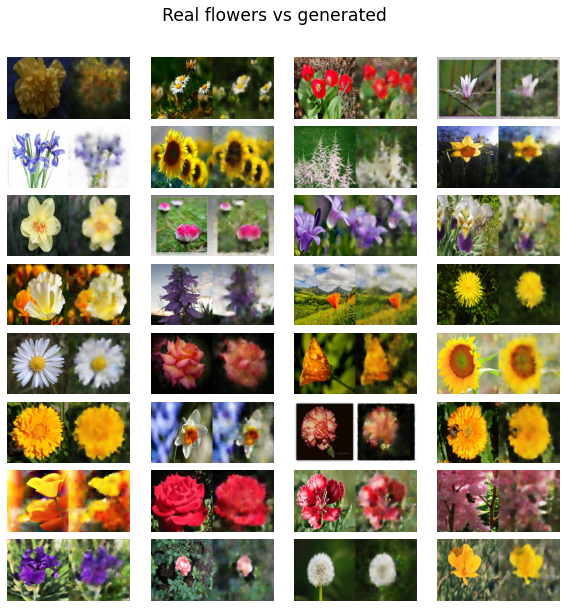

In [12]:
X_flowers = next(flowers_gen.flow(training=False))
Y_flowers = flowers_ae.autoencoder.predict(X_flowers)

fig, axes = plt.subplots(8, 4, figsize=(10, 10))
fig.subplots_adjust(wspace=0.12, hspace=.12)
for i, ax in enumerate(axes.ravel()):
  dual = np.hstack((X_flowers[i], Y_flowers[i]))
  ax.imshow(dual)
  ax.set_axis_off()

fig.suptitle('Real flowers vs generated', y=0.95, fontsize='xx-large')
plt.show()

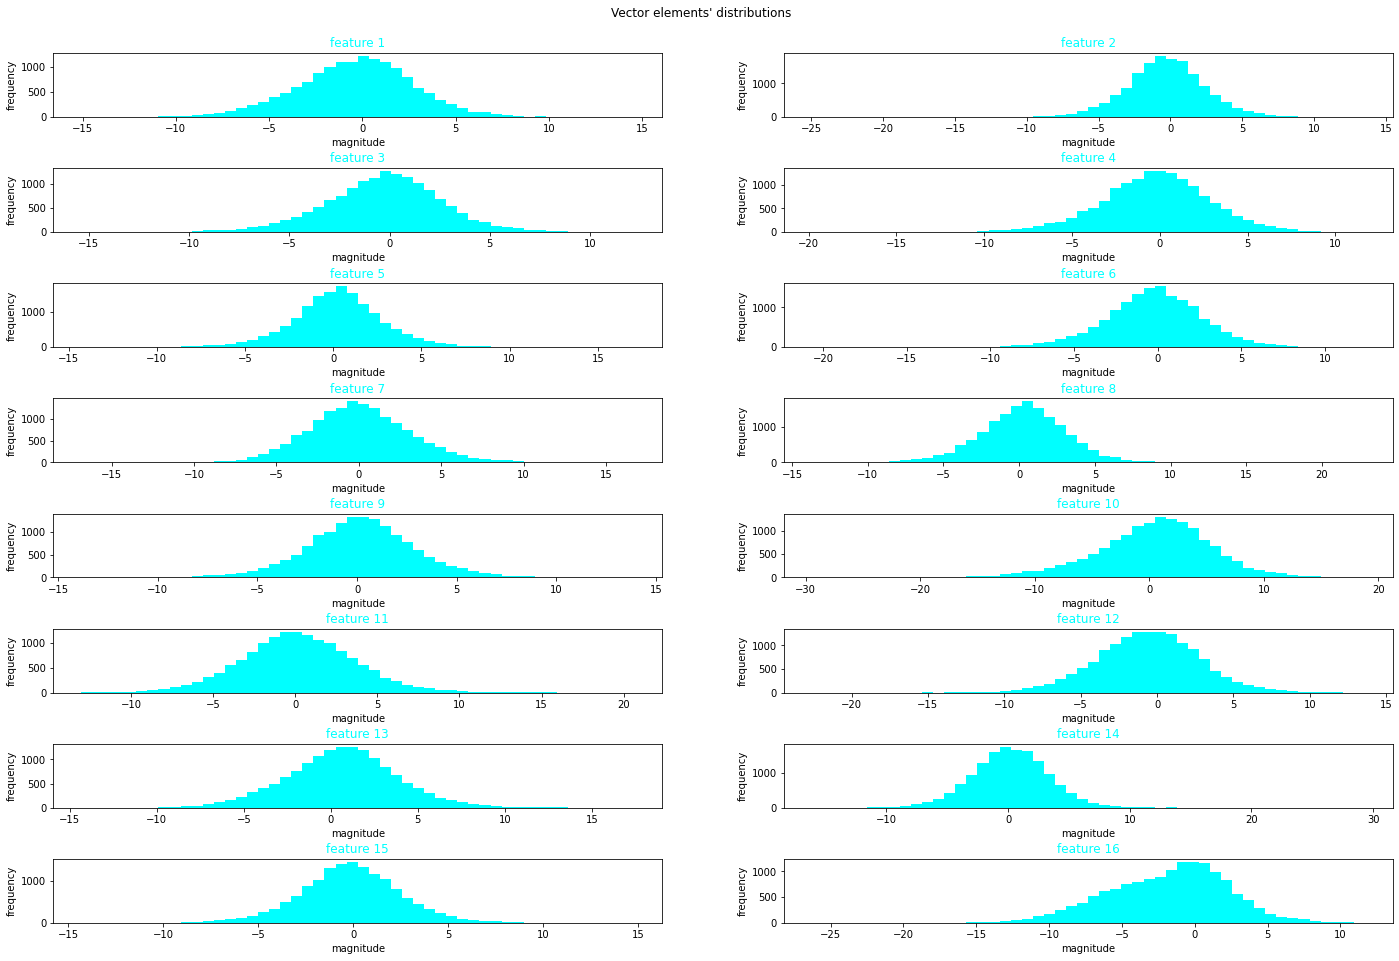

In [13]:
flowers_gen.reset_index()
flowers_encoded = flowers_ae.encoder.predict(
    flowers_gen.flow(training=False), steps=len(flowers_gen.files) // batch_size
)


fig, axes = plt.subplots(8, 2, figsize=(24,16))
fig.subplots_adjust(wspace=0.2, hspace=0.8)

for i, ax in enumerate(axes.ravel()):
  ax.hist(flowers_encoded[:, i], bins=50, color='cyan')
  ax.set_xlabel('magnitude')
  ax.set_ylabel('frequency')
  ax.set_title(f'feature {i+1}', fontdict={'color':'cyan'})

fig.suptitle("Vector elements' distributions", y=0.92)
plt.show()